# Simple RNN을 이용한 SMS Spam 분류
- Kaggle data: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [1]:
import pandas as pd 
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [4]:
df = pd.read_csv(url, encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


### 1. 데이터 전처리

In [5]:
# Selection -  'v1', 'v2'
df = df[['v1', 'v2']]
df.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
# Null data check
df.isna().sum().sum()

0

In [9]:
# duplicates data check
df.shape, df.v2.nunique()

((5572, 2), 5169)

In [10]:
# drop duplicates data
df.drop_duplicates(subset=['v2'], inplace=True)
df.shape

(5169, 2)

In [11]:
# ['ham', 'spam] --> [0, 1]
df.v1 = df.v1.replace(['ham', 'spam'], [0, 1])  # 2개 밖에 없어서 그냥 replace로 바꿔줘도 됨
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [13]:
# Ham/Spam 분포
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [ ]:
# 전처리 완료된 파일을 만들어 저장 
df.to_csv('스팸_처리_완료.csv')

In [14]:
x, y = df.v2.values, df.v1.values
x.shape, y.shape

((5169,), (5169,))

### 2. `Keras` - 텍스트 전처리

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
# encoding, 구둣점 제거, 소문자로 변환 
import re
def preprocessing(s):
  s = s.encode('utf8').decode('ascii', 'ignore') # 이상한 데이터 없애기 위해 encode->decode
  s = re.sub('[^A-Za-z0-9 ]', '', s.lower() )    # 구둣점 제거, 소문자로 변경 
  return s                               

In [18]:
X_data = [preprocessing(sent) for sent in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [19]:
# 단어 집합 생성 
t = Tokenizer()
t.fit_on_texts(X_data)

vocab_size = len(t.word_index) + 1
vocab_size

9479

In [20]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [21]:
max_len = max(len(seq) for seq in sequences)
max_len

171

In [22]:
# 전체 데이터픞 max_len 길이에 맞도록 0 padding 
data = pad_sequences(sequences, maxlen=max_len)

- train/test data set 분리

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=0.2, random_state=2022)
X_train.shape ,X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [32]:
model = Sequential([
                    Embedding(vocab_size, 32, input_length=max_len), # y가 별도로 있어서 max_len-1 (X)
                    SimpleRNN(32), 
                    Dense(1, activation='sigmoid')
])
model.summary()

model.compile('adam', 'binary_crossentropy', ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 32)           303328    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_path = 'best-spam-run.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

In [35]:
hist = model.fit(
    X_train, y_train, validation_split=0.2,
    epochs=100, batch_size=64, callbacks=[mc,es]
)

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8558
Epoch 1: val_loss improved from inf to 0.24656, saving model to best-spam-run.h5
52/52 [==============================] - 7s 93ms/step - loss: 0.4025 - accuracy: 0.8558 - val_loss: 0.2466 - val_accuracy: 0.8984
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9516
Epoch 2: val_loss improved from 0.24656 to 0.12403, saving model to best-spam-run.h5
52/52 [==============================] - 5s 89ms/step - loss: 0.1692 - accuracy: 0.9516 - val_loss: 0.1240 - val_accuracy: 0.9686
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9843
Epoch 3: val_loss improved from 0.12403 to 0.09619, saving model to best-spam-run.h5
52/52 [==============================] - 4s 81ms/step - loss: 0.0722 - accuracy: 0.9843 - val_loss: 0.0962 - val_accuracy: 0.9722
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 0.038

In [36]:
def plotting(hist, title):
  y_acc = hist.history['accuracy']
  y_loss = hist.history['loss']
  xs = np.arange(1, len(y_acc)+1)

  plt.figure(figsize=(12,8))
  plt.plot(xs, y_acc, label='accuracy')
  plt.plot(xs, y_loss, label='loss')
  plt.legend(), plt.grid()
  plt.ylim(0,1.2), plt.xlabel('Epoch')
  plt.title(title)
  plt.show()

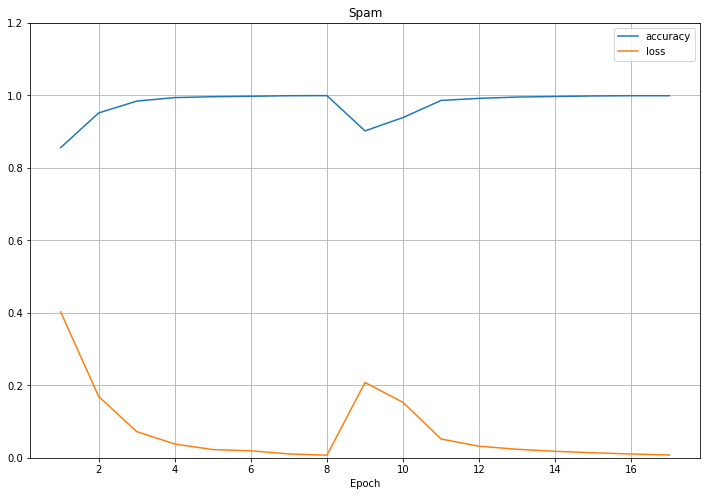

In [37]:
plotting(hist,'Spam')